In [53]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import py_tps as tps
from PIL import Image

from torch import nn
from torchvision import datasets, models, transforms
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
from skimage.segmentation import disk_level_set

import time
import pickle

from models import U_Net

In [54]:
class LandmarksDataset():
    def __init__(self): # инициация программы и установление основных значений
        self.drive_dir = '../data/interin' # <- Путь до папки где лежит папка на которых будим учится
        self.image_dir = 'Ac_Fom_2022_WM_scale' # <- Название папки с исходными фото и файлом *.TPS
        self.tps_file_name = 'Ac_Fom2022WM_FL_scale.TPS' # <- Название файла *.TPS
        self.tps_file = tps.TPSFile.read_file(os.path.join(self.drive_dir, self.image_dir, self.tps_file_name))
        self.transform = False # <- Нужно ли трасформировать исходные изображения, если нужно параметры для трансформации в поле self.params
        self.disk_radius = 2
        self.params = {'rotation_range':[40], 'zoom_range':[0.7,1.3], 'height_shift_range':[-0.05, 0.05], 'width_shift_range':[-0.05, 0.05], 'contrast_range':1}

    def __getitem__(self, index): # получение изображения и коррдинат точек к нему, случайное изменение изображения, перевод изображения в формат torch

        # Загрузка фото и его перевод в массив numpy, определение размера в пиксилях
        image = Image.open(os.path.join(self.drive_dir, self.image_dir, self.tps_file.images[index].image))
        image_array = np.array(image)
        image_shape = image_array.shape
    
        # Загрузка ландмарок и их зеркальное отображение по вертикали
        landmarks = self.tps_file.images[index].landmarks.points
        landmarks_flip = np.zeros(landmarks.shape)
        landmarks_flip[:,0] = landmarks[:,0]
        landmarks_flip[:,1] = image_shape[0] - landmarks[:,1]
        params = self.params

        # Масштабирование исходного изображения и его нормировка
        img_shape = image.size
        image = TF.resize(image, (224,224))
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5],[0.5])

        # Масштабирование ландмарок и их нормировка
        landmarks_flip = torch.tensor(landmarks_flip)/torch.tensor([img_shape[0],img_shape[1]])

        # Создание масок
        c, shape, n = image.shape
        landmarks_masks = []
        for landmark in landmarks_flip:
            mask = disk_level_set(image_shape=(shape,shape), center=(landmark[1]*224,landmark[0]*224), radius=self.disk_radius)
            landmarks_masks.append(mask)
        landmarks_masks = np.array(landmarks_masks).astype(np.float32)
        landmarks_masks = torch.from_numpy(landmarks_masks)
        
        landmarks_flip = landmarks_flip.clone().detach() - 0.5

        return image, landmarks_flip, landmarks_masks

    def __len__(self):
        return len(self.tps_file.images)

In [55]:
class UnNormalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    for t, m ,s in zip(tensor, self.mean, self.std):
      t.mul_(s).add_(m)
    return tensor

19 torch.Size([224, 224]) <function amax at 0x7b93f4795bc0>


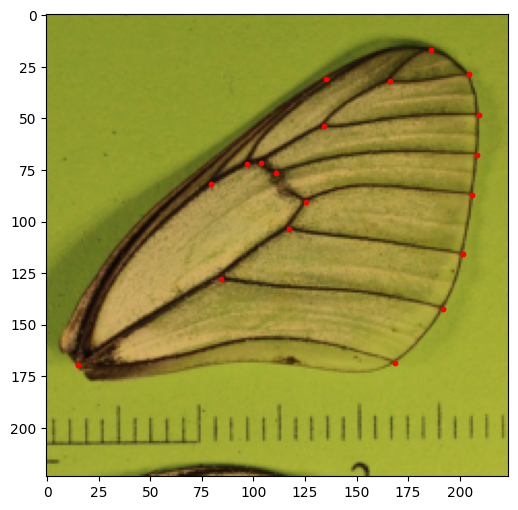

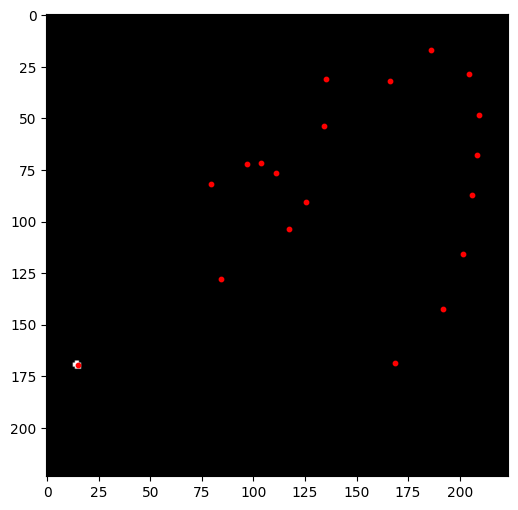

In [56]:
dataset = LandmarksDataset()

image, landmarks, masks = dataset[-1]
print(len(masks), masks[0].shape, np.amax)
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
image = unorm(image)

landmarks = (landmarks + 0.5) * torch.tensor([224, 224])
image = image.permute(1, 2, 0).numpy()

plt.figure(figsize=(10,6))
plt.imshow(image)
plt.scatter(landmarks[:,0], landmarks[:,1], s=10, color ='r')
plt.figure(figsize=(10,6))
plt.imshow(masks[0], cmap="gray")
plt.scatter(landmarks[:,0], landmarks[:,1], s=10, color ='r')

In [57]:
len_valid_test_set = int(0.1*len(dataset)) # 80% тренировочная выборка, 10% валидационная выборка, 10% тестовая выборка

len_train_set = len(dataset) - len_valid_test_set*2

print("Длина тренировочной выборки {}".format(len_train_set))
print("Длина валидационной выборки {}".format(len_valid_test_set))
print("Длина тестовой выборки {}".format(len_valid_test_set))

train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_test_set, len_valid_test_set], generator=torch.Generator().manual_seed(38))

# Смешивание и объединение наборов данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,batch_sampler=None, shuffle=False)

Длина тренировочной выборки 225
Длина валидационной выборки 28
Длина тестовой выборки 28


In [58]:
network = U_Net(3, 19)
network.cpu()

U_Net(
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [59]:
# network.load_state_dict(torch.load('../data/interin/Ac_Fom_2022_WM_scale/model_unet_segment_finetune_NoTransF_0.pth', map_location=torch.device('cpu')))

In [60]:
def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.8f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.8f " % (step, total_step, loss))

    sys.stdout.flush()

In [61]:
calc_loss = nn.CrossEntropyLoss()

torch.autograd.set_detect_anomaly(True)

loss_list = {'train': [], 'val':[], 'time': []}

initial_lr = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=initial_lr) # try SGD
#opt = optim.SGD(model_test.parameters(), lr = initial_lr, momentum=0.99)

MAX_STEP = int(1e10)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, MAX_STEP, eta_min=1e-5, verbose = True)

loss_min = np.inf
num_epochs = 100

start_time = time.time()
for epoch in range(0,num_epochs):
    loss_train = 0
    loss_valid = 0
    running_loss = 0

    network.train()
    for step in range(1, len(train_loader)+1):

        images, landmarks, masks = next(iter(train_loader))

        images = images.cpu()
#         landmarks = landmarks.view(landmarks.size(0),-1).cpu()
        masks = masks.cpu()
        predictions = network(images)

        optimizer.zero_grad()

        loss_train_step = calc_loss(predictions, masks)

        loss_train_step.backward()


        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        print_overwrite(step, len(train_loader), running_loss, 'train')


    network.eval()
    with torch.no_grad():

        for step in range(1,len(valid_loader)+1):


            images, landmarks, masks = next(iter(valid_loader))

            images = images.cpu()
#             landmarks = landmarks.view(landmarks.size(0),-1).cuda()
            masks = masks.cpu()
            predictions = network(images)

            loss_valid_step = calc_loss(predictions, masks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    print('\n--------------------------------------------------')
    print('Эпоха: {}  Train Loss: {:.8f}  Valid Loss: {:.8f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    loss_list['train'].append(loss_train)
    loss_list['val'].append(loss_valid)
    #loss_list['time'].append(time.time()-start_time)
    f = open("../data/interin/Ac_Fom_2022_WM_scale/model_unet_NoTransF_trainingdata_0.pkl","wb")
    pickle.dump(loss_list,f)
    f.close()
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '../data/interin/Ac_Fom_2022_WM_scale/model_unet_segment_finetune_NoTransF_0.pth')
        print('Минимальная ошибка валидации Valid loss: {:.8f} на эпохе {}'.format(loss_min, epoch, num_epochs))
        print('Модель сохранена\n')

print('Обучение завершено')
print('Всего затрачено времени: {} c.'.format(time.time()-start_time))
loss_list['time'].append(time.time()-start_time)

Valid Steps: 2/2  Loss: 0.01399358 7 
--------------------------------------------------
Эпоха: 0  Train Loss: 0.00776577  Valid Loss: 0.01399358
--------------------------------------------------
Минимальная ошибка валидации Valid loss: 0.01399358 на эпохе 0
Модель сохранена

Valid Steps: 2/2  Loss: 0.01313818 7 
--------------------------------------------------
Эпоха: 1  Train Loss: 0.00143127  Valid Loss: 0.01313818
--------------------------------------------------
Минимальная ошибка валидации Valid loss: 0.01313818 на эпохе 1
Модель сохранена

Valid Steps: 2/2  Loss: 0.01018986 0 
--------------------------------------------------
Эпоха: 2  Train Loss: 0.00079860  Valid Loss: 0.01018986
--------------------------------------------------
Минимальная ошибка валидации Valid loss: 0.01018986 на эпохе 2
Модель сохранена

Valid Steps: 2/2  Loss: 0.00232784 1 
--------------------------------------------------
Эпоха: 3  Train Loss: 0.00035221  Valid Loss: 0.00232784
--------------------

In [87]:
def get_predicted_landmarks(predicted_masks):
    landmarks = []
    for mask in predicted_masks[0]:
        prediction_s = mask.cpu().numpy()
        seventh_max = np.sort(prediction_s.flatten())[-7]

        mask_indices = np.argwhere(prediction_s >= seventh_max) 
        landmark = np.mean(mask_indices, axis=0)
        landmarks.append([landmark[1]*1024/224, landmark[0]*1024/224])
        #landmarks.append([landmark[1]*1280/224, landmark[0]*1024/224])
#         landmarks.append([landmark[1], landmark[0]])
        
    return torch.from_numpy(np.array(landmarks))

In [88]:
def get_predicted_masks(predicted_masks):
    masks = []
    for mask in predicted_masks:
        prediction_s = mask#.cpu().numpy()
#         print("Prediction s 1", prediction_s.shape)
        seventh_max = np.sort(prediction_s.flatten())[-7]
        prediction_s[prediction_s < seventh_max] = 0
        prediction_s[prediction_s >= seventh_max] = 1
        
#         print("Prediction s", prediction_s.shape)
        masks.append(prediction_s)
    return masks

In [89]:
#networkf = network()
#networkf.load_state_dict(torch.load('../data/interin/Ac_Fom_2022_WM_scale/model_unet_segment_finetune_NoTransF_0.pth', map_location=torch.device('cpu')))
#networkf.cpu()
#resnet50f.cuda()
#torch.autograd.set_detect_anomaly(True)

In [91]:
network.eval()

predictions = torch.zeros(28, 19, 2).detach()
landmarks = torch.zeros(28, 19, 2).detach()
image_plot = 0
#images, landmarks = next(iter(test_loader))
images_plot = []
counter = 0
print("evaluating on test set")
with torch.no_grad():
    for images, landmark, masks in test_loader:
#         print("shape", images.shape)
#         break
        images = images.reshape((1,3,224,224))#.cuda()
        image_plot = images[-1].cpu().numpy() if counter == 0 else image_plot
        images_plot.append(images)
#         landmark = ((landmark + 0.5 )*torch.tensor([224, 224])).cuda()
        landmark = ((landmark + 0.5 )*torch.tensor([1024,1024]))#.cuda()
        masks = masks#.cuda()
        # why the + 0.5
#         prediction = network(images)['out']
        prediction = network(images)
#         plot_prediction = prediction[0].cpu().numpy()
        
#         plot_prediction = get_predicted_masks(plot_prediction)
        j = 0
        
        # Oobtains landmarks form masks
        prediction = get_predicted_landmarks(prediction)

#         for mask in plot_prediction:
# #             print(np.amax(mask))
#             plt.figure()
#             plt.imshow(mask, cmap="gray")
#             plt.scatter(landmark[j][0].cpu().numpy()*224/1280, landmark[j][1].cpu().numpy()*224/1024, s=10, color ='r')
#             plt.scatter(prediction[j][0].cpu().numpy()*224/1024, prediction[j][1].cpu().numpy()*224/1280, s=10, color ='y')

#             j+=1
            
#         plt.show()
#         print(prediction.shape)
        
#         prediction = get_predicted_landmarks(masks)

        landmarks[counter,:] = landmark
        predictions[counter,:] = prediction
        predictions.detach()
        counter += 1
endtime = time.time()-start_time
print(endtime)

evaluating on test set
80645.58663320541


In [92]:
masks.shape

torch.Size([19, 224, 224])

In [93]:
predictions.shape

torch.Size([28, 19, 2])

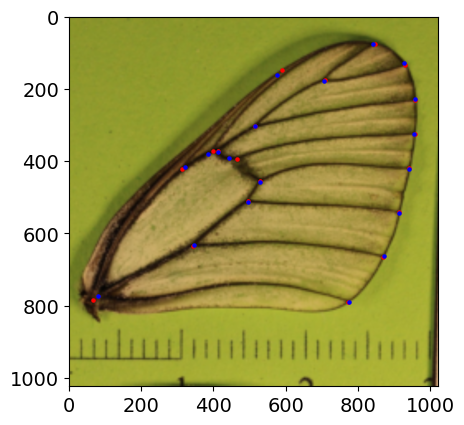

In [98]:
#unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#images = unorm(images).squeeze()
#images = images.permute(1, 2, 0).numpy()
from skimage.transform import resize
images1 = resize(images, (1024, 1024))

plt.imshow(images1)
plt.scatter(landmark[:,0],landmark[:,1], color = 'red' , s = 5)
plt.scatter(prediction[:,0],prediction[:,1], color = 'blue' , s = 5)
plt.savefig('example.jpg')
plt.show()


In [69]:
difs = abs(predictions - landmarks)
difs = difs.detach()
dis = np.sqrt(difs[:, :,0]**2 + difs[:, :, 1]**2)
av = []
for I in dis:
  av.append(np.mean(I.numpy()))
print(np.mean(av))
print(np.std(av))

1.3564245
0.33667085


In [70]:
dis.size()

torch.Size([28, 19])

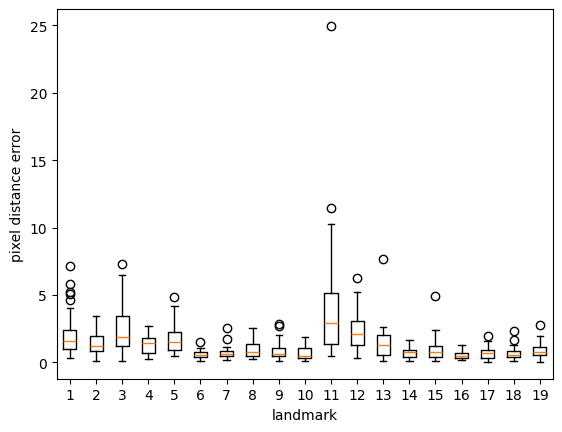

In [71]:
fig = plt.figure()
plt.boxplot(dis)
plt.xlabel('landmark')
plt.ylabel('pixel distance error')
plt.show()

In [72]:
difs = abs(predictions - landmarks)
difs = difs.detach()
dis = difs[:, :,0]**2 + difs[:, :, 1]**2
rms = np.sqrt(dis.sum(axis=0)/dis.shape[0])
rms.mean()

tensor(1.7128)

In [73]:
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.
    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.
        d, Z, [tform] = procrustes(X, Y)
    Inputs:
    ------------
    X, Y
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.
    scaling
        if False, the scaling component of the transformation is forced
        to 1
    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.
    Outputs
    ------------
    d
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()
    Z
        the matrix of transformed Y-values
    tform
        a dict specifying the rotation, translation and scaling that
        maps X --> Y
    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection != 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform
def generalized_procrustes(data):
    mean = data[0,...]
    print('Aligning')
    d = 100
    d_old = 100
    while d > 0.0001:
        d_new = 0
        for i in range(data.shape[0]):
            d_, data[i,:], _ = procrustes(mean, data[i,:], scaling=False, reflection=False)
            d_new += d_ / data.shape[0]
        d = d_old - d_new
        d_old = d_new
        mean = data.mean(axis=0)
    return mean

mean = generalized_procrustes(landmarks)

Aligning


In [74]:
from scipy.spatial import procrustes as procrustes_ 
procrustes_errors = {'error':[], 'procrustes_disparity':[]}
for i in range(28):
    procrustes_errors['error'].append(av[i])
    mtx1, mtx2, disparity = procrustes_(mean, landmarks[i])
    procrustes_errors['procrustes_disparity'].append(disparity)

In [75]:
proc = []
#for i in procrustes_errors['procrustes_disparity']:
#    if i>0.001:
#        proc.append(i)
errors = []
for it, i in enumerate(procrustes_errors['error']):
    #$print(it)
    mean_err = np.mean(procrustes_errors['error'])
    mean_disp = np.mean(procrustes_errors['procrustes_disparity'])
    std_err = np.std(procrustes_errors['error'])*2
    std_disp = np.std(procrustes_errors['procrustes_disparity'])*2
    i_p = procrustes_errors['procrustes_disparity'][it]
    if (mean_err - std_err)<i<(mean_err + std_err) and (mean_disp-std_disp)<i_p<(mean_disp + std_disp):
        errors.append(i)
        proc.append(procrustes_errors['procrustes_disparity'][it])

0.07
89.17


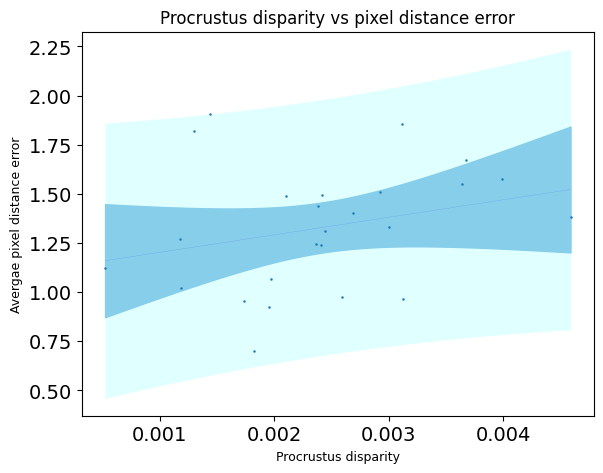

In [77]:
import scipy.stats as stats
weights  = proc#procrustes_errors['procrustes_disparity']

heights = errors#procrustes_errors['error']

x = weights#/max(weights)

y = heights#/max(heights)
slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

y_model = np.polyval([slope, intercept], x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = len(x)                       # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = y - y_model

std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# to plot the adjusted model
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = np.polyval([slope, intercept], x_line)

# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

############### Ploting
plt.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.add_axes([.1, .1, .8, .8])

#, 'o', color = 'royalblue')
ax.plot(x_line, y_line, color = 'royalblue', linewidth=0.1)
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval', linewidth=0.1)
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')
ax.scatter(x, y, s = 0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')

# rounding and position must be changed for each case and preference
a = str(np.round(intercept))
b = str(np.round(slope,2))
r2s = str(np.round(r2,2))
MSEs = str(np.round(MSE))

#ax.text(45, 110, 'y = ' + a + ' + ' + b + ' x')
#ax.text(45, 100, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)
plt.title('Procrustus disparity vs pixel distance error',  fontsize=12)
plt.ylabel('Avergae pixel distance error',fontsize=9)
plt.xlabel('Procrustus disparity',fontsize=9)
#plt.plot([0,0.6],[0.38,0.38], linewidth=0.5, c='g', label = 'Median average pixel distance error')
#plt.plot([0.118,0.118],[0.0,1], linewidth=0.5, c='r', label = 'Median procrustus disparity')
#plt.legend( fontsize=8)
#plt.xlim([0.0,0.005])
#plt.ylim([0.0,40])
#plt.savefig('linear_reg.png')
print(r2s)
print(b)

Text(0, 0.5, 'Frequency')

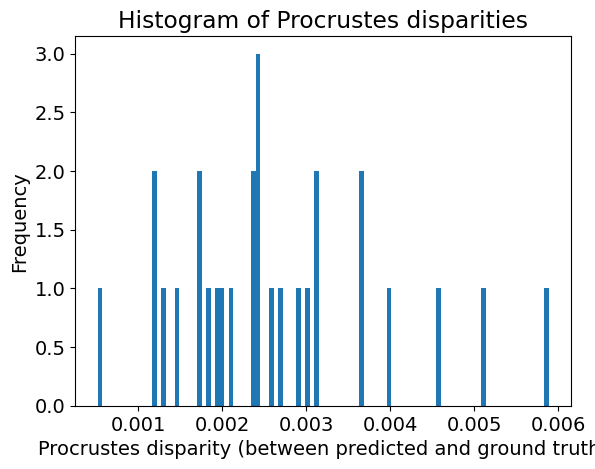

In [78]:
plt.hist(procrustes_errors['procrustes_disparity'], bins = 100)
plt.title('Histogram of Procrustes disparities')
plt.xlabel('Procrustes disparity (between predicted and ground truth)')
#plt.xlim((0,0.0012))
plt.ylabel('Frequency')